# Introduction to Forecasting
* Goals
  * Compare a Holt-Winters forecasted model to known data
  * Understand <em>stationarity</em>, <em>differencing</em> and <em>lagging</em>
  * Introduce ARIMA and describe next steps

### <font color=blue>Simple Exponential Smoothing / Simple Moving Average</font>
This is the simplest to forecast. $\hat{y}$ is equal to the most recent value in the dataset, and the forecast plot is simply a horizontal line extending from the most recent value.
### <font color=blue>Double Exponential Smoothing / Holt's Method</font>
This model takes trend into account. Here the forecast plot is still a straight line extending from the most recent value, but it has slope.
### <font color=blue>Triple Exponential Smoothing / Holt-Winters Method</font>
This model has (so far) the "best" looking forecast plot, as it takes seasonality into account. When we expect regular fluctuations in the future, this model attempts to map the seasonal behavior.

## Forecasting with the Holt-Winters Method


In [1]:
import matplotlib.pyplot as plt
import time
from scipy.fftpack import fft
from scipy import signal
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from numpy import fft as npfft
import pylab as pl
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
%matplotlib inline
path = 'data_zero.csv'
df=pd.read_csv(path)
columns_names = df.columns
df.index = pd.to_datetime(df[columns_names[0]]/1000, unit='s')
# df.drop(columns[0], axis = 1)
delite_column = columns_names[0]
df = df.drop(delite_column, axis = 1) 
# df.sort_index(inplace= True)
df.sort_index(inplace= True)
df = df.asfreq(freq='1S')

# taking_of_nan_values_DF(dfx)

In [2]:
def taking_of_nan_values_DF(dfx):
    # interpolation
    dfx = dfx.interpolate(method='linear', limit_direction='forward', axis=0)
    # taking of nullmi
    dfx = dfx.fillna(method='ffill')
    dfx = dfx.fillna(method='bfill')
    return dfx

In [3]:
df = taking_of_nan_values_DF(df)
df.head()
df.tail()

,P20113,P20110,P10216,P10215,P10116,P10115,P10110,P7500
miliseka,,,,,,,,
2013-04-24 08:02:43.569999933,-0.001251,-0.000629,0.020937,0.020939,0.002502,0.006876,-0.003437,-0.003437
2013-04-24 08:02:44.569999933,0.003437,0.001873,0.009375,0.010941,0.005314,0.009686,0.002187,0.002188
2013-04-24 08:02:45.569999933,0.040312,0.039684,0.021563,0.025003,0.008125,0.005314,0.002188,0.001875
2013-04-24 08:02:46.569999933,0.030622,0.023746,0.021875,0.025002,0.005938,0.006561,0.008750,0.006562
2013-04-24 08:02:47.569999933,0.014685,0.015625,0.027811,0.033752,0.000315,0.002815,0.009688,0.007500


In [4]:
df.describe()

,P20113,P20110,P10216,P10215,P10116,P10115,P10110,P7500
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.037945,0.037128,0.030706,0.032265,0.011862,0.013910,0.003072,0.003626
std,0.021944,0.023078,0.022598,0.030328,0.017098,0.017264,0.003855,0.003840
min,-0.036875,-0.032816,-0.098124,-0.154686,-0.088753,-0.081562,-0.020312,-0.025625
25%,0.023748,0.022808,0.022734,0.025942,0.006248,0.008357,0.000937,0.001250
50%,0.040314,0.039997,0.035938,0.039066,0.016563,0.018751,0.003125,0.003750
75%,0.053514,0.053122,0.044374,0.047813,0.022186,0.024374,0.005625,0.005938
max,0.102188,0.099371,0.069376,0.072191,0.039062,0.041561,0.023125,0.023438


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1200 entries, 2013-04-24 07:42:48.569999933 to 2013-04-24 08:02:47.569999933
Freq: S
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P20113  1200 non-null   float64
 1   P20110  1200 non-null   float64
 2   P10216  1200 non-null   float64
 3   P10215  1200 non-null   float64
 4   P10116  1200 non-null   float64
 5   P10115  1200 non-null   float64
 6   P10110  1200 non-null   float64
 7   P7500   1200 non-null   float64
dtypes: float64(8)
memory usage: 84.4 KB


## Fitting the Model comparison of real and forecasted data

In [6]:
def predict_compare(df):

    
    train_data = df.iloc[:int(len(df)*0.6)]
    test_data = df.iloc[int(len(df)*0.6):]
    
    length = len(train_data)
    length_10_proc = int(length/2)
    length_10_proc

    columns = df.columns
    for column in columns:
        fitted_model = ExponentialSmoothing(train_data[column], trend='add',seasonal='add',seasonal_periods=length_10_proc).fit()
        # Evaluating Model against Test Set
        test_predictions = fitted_model.forecast(len(df)*0.4).rename('HW Forecast')

        plt.figure(figsize=(20, 6))
        plt.plot(train_data[column],label='TRAIN'+column)
        plt.plot(test_data[column], label='TEST'+column)
        plt.plot(test_predictions, label='PREDICTION'+ column);

        plt.title('Fitting the Model'+ column)
        plt.xlabel('time')
        plt.ylabel('Value')
        plt.grid()
        plt.show() 
        
        # Evaluation Metrics
        mean_absolute_error_value = mean_absolute_error(train_data[:len(test_data)],test_data[:len(test_data)])
        print(mean_absolute_error_value)
        
        mean_squared_error_value = mean_squared_error(train_data[:len(test_data)],test_data[:len(test_data)])
        print(mean_squared_error_value)
        
        np_sqrt_mean_squared_error =np.sqrt(mean_squared_error(train_data[:len(test_data)],test_data[:len(test_data)]))
        print(np_sqrt_mean_squared_error)
        
        print(test_data.describe())
        
        


C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


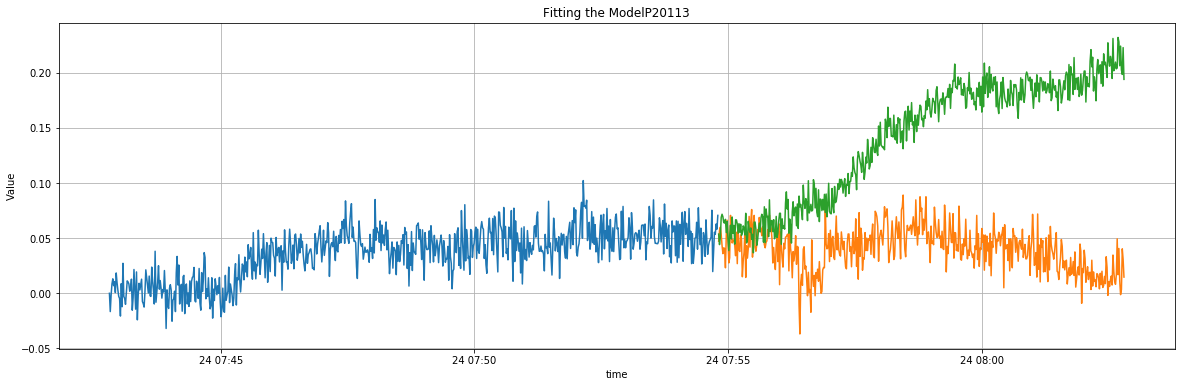

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


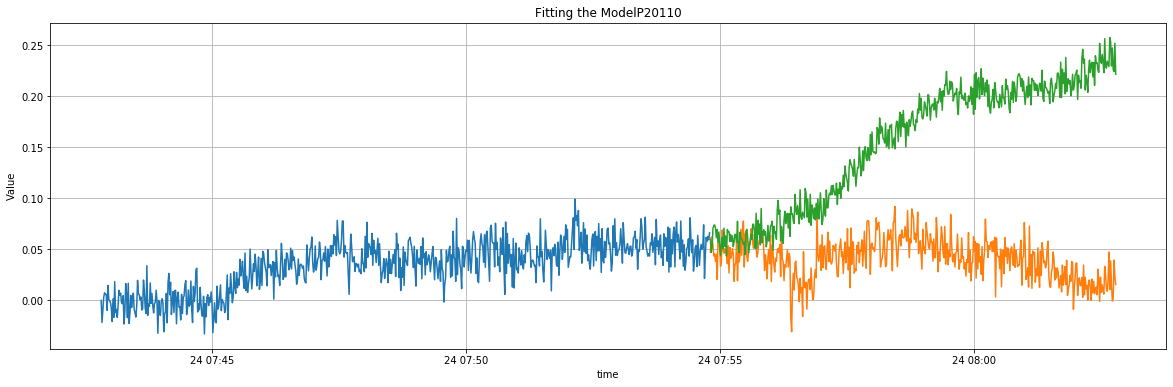

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


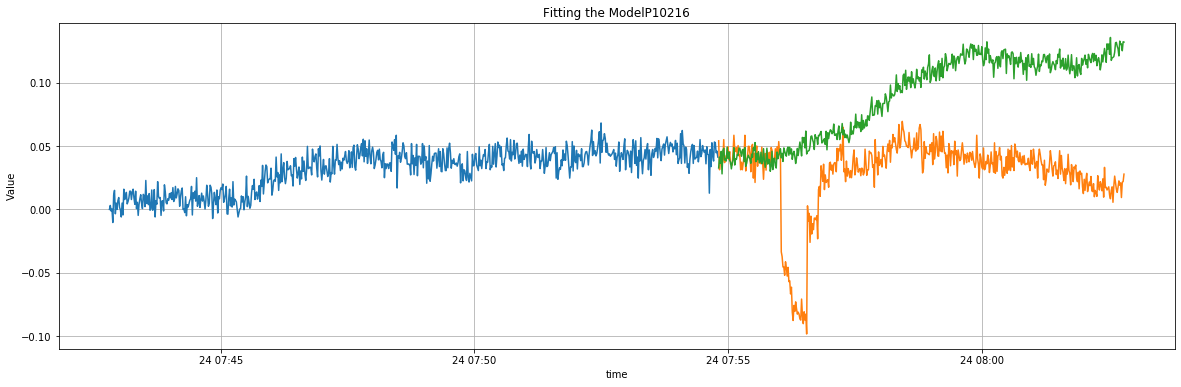

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


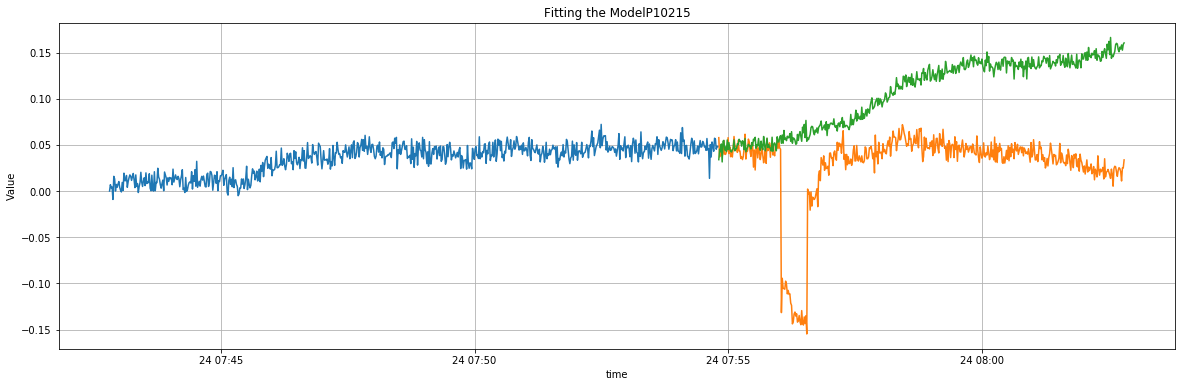

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


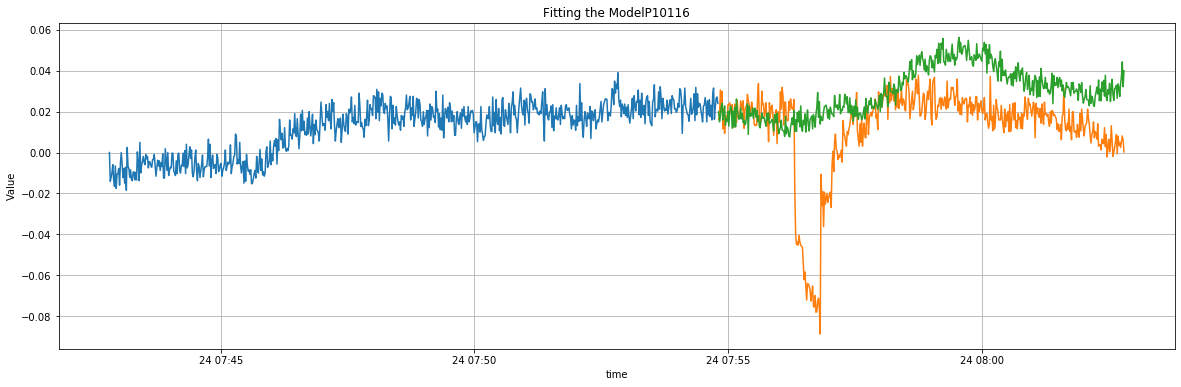

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


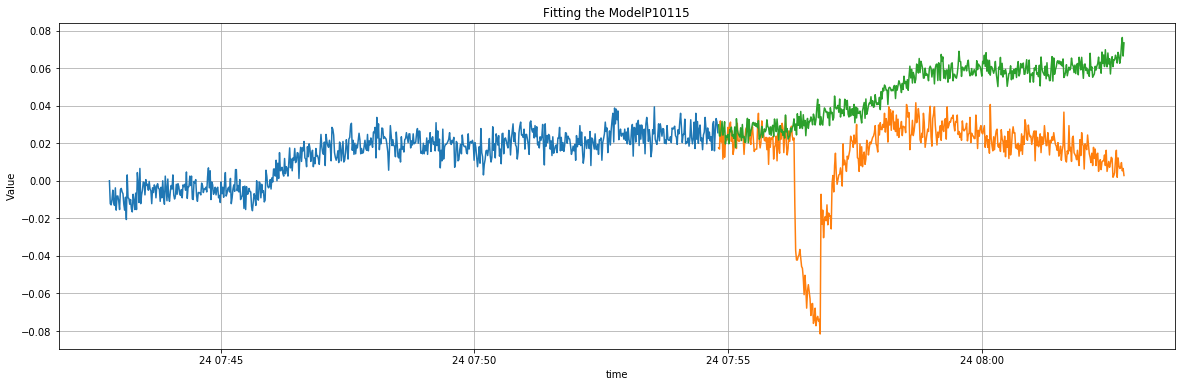

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

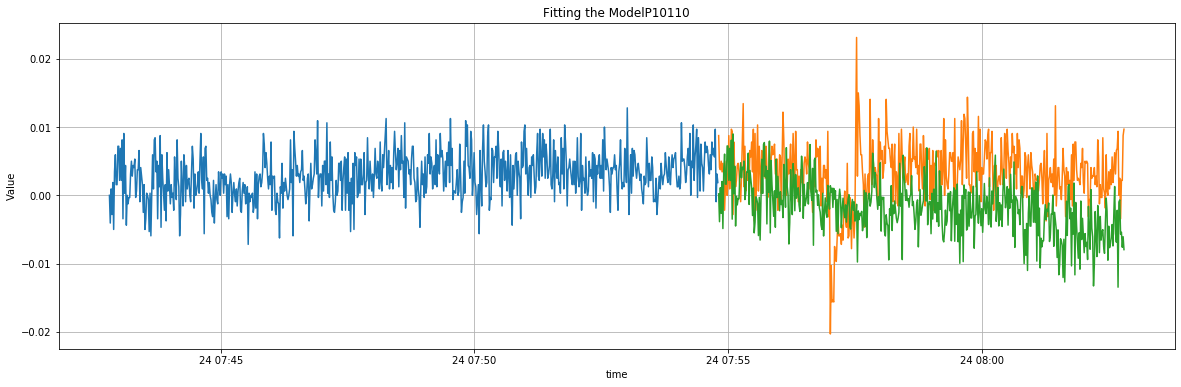

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

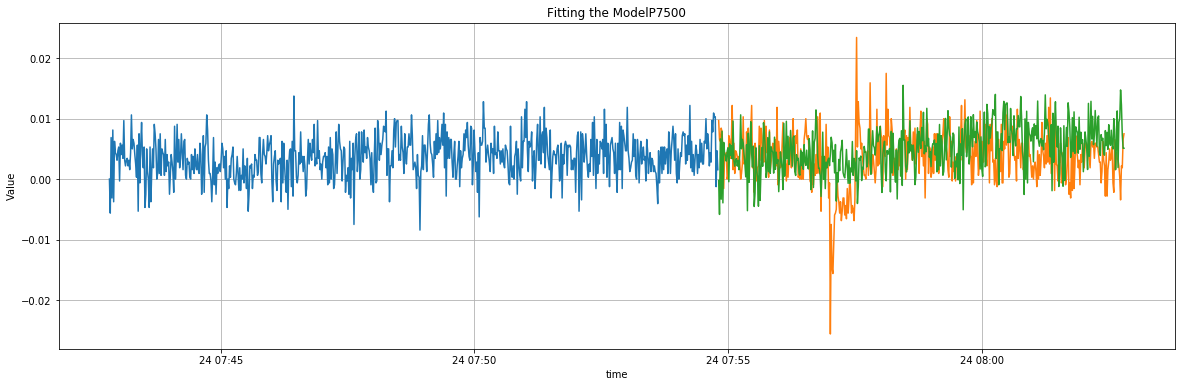

0.01875927932560438
0.0007680709630665958
0.027714093221077898
           P20113      P20110      P10216      P10215      P10116      P10115  \
count  480.000000  480.000000  480.000000  480.000000  480.000000  480.000000   
mean     0.039913    0.041258    0.028958    0.028479    0.012005    0.014993   
std      0.019404    0.019908    0.029476    0.043283    0.022191    0.022101   
min     -0.036875   -0.030628   -0.098124   -0.154686   -0.088753   -0.081562   
25%      0.026249    0.027730    0.026247    0.029691    0.010313    0.013126   
50%      0.041405    0.042810    0.035937    0.039379    0.017815    0.020939   
75%      0.053436    0.055387    0.044686    0.047892    0.023438    0.026249   
max      0.089060    0.092188    0.069376    0.071878    0.037811    0.041561   

           P10110       P7500  
count  480.000000  480.000000  
mean     0.003356    0.003643  
std      0.004487    0.004428  
min     -0.020312   -0.025625  
25%      0.000937    0.001484  
50%      0.0034

In [7]:
predict_compare(df)

# Predicted data

In [8]:
def prediction_data(df):  

    train_data = df.iloc[:int(len(df))]
    test_data = df.iloc[int(len(df)):]
    
    length = len(train_data)
    length_10_proc = int(length/10)
    length_10_proc

    columns = df.columns
    for column in columns:
        fitted_model = ExponentialSmoothing(train_data[column], trend='add',seasonal='add',seasonal_periods=length_10_proc).fit()
        # Evaluating Model against Test Set
        test_predictions = fitted_model.forecast(len(df)*0.2).rename('HW Forecast')

        plt.figure(figsize=(20, 6))
        plt.plot(train_data[column],label='TRAIN'+column)
        plt.plot(test_data[column], label='TEST'+column)
        plt.plot(test_predictions, label='PREDICTION'+ column);

        plt.title('Fitting the Model'+ column)
        plt.xlabel('time')
        plt.ylabel('Value')
        plt.grid()
        plt.show() 
        
     
    
   

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


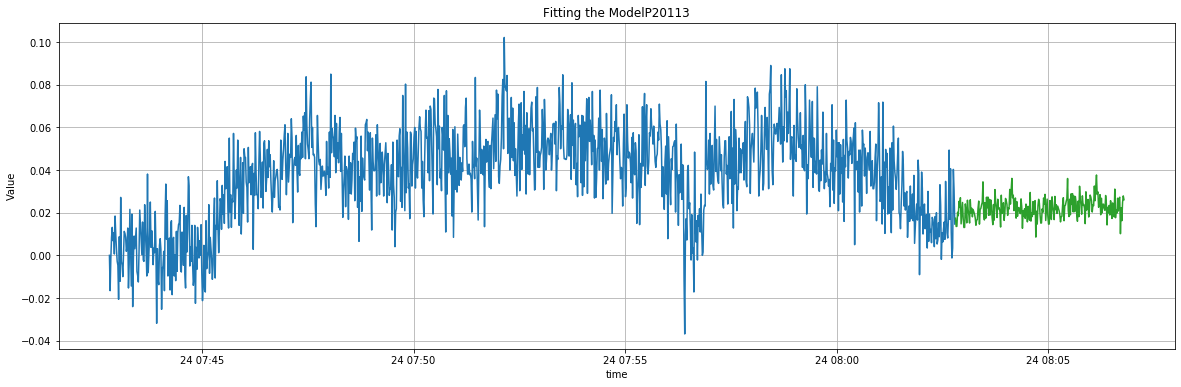

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


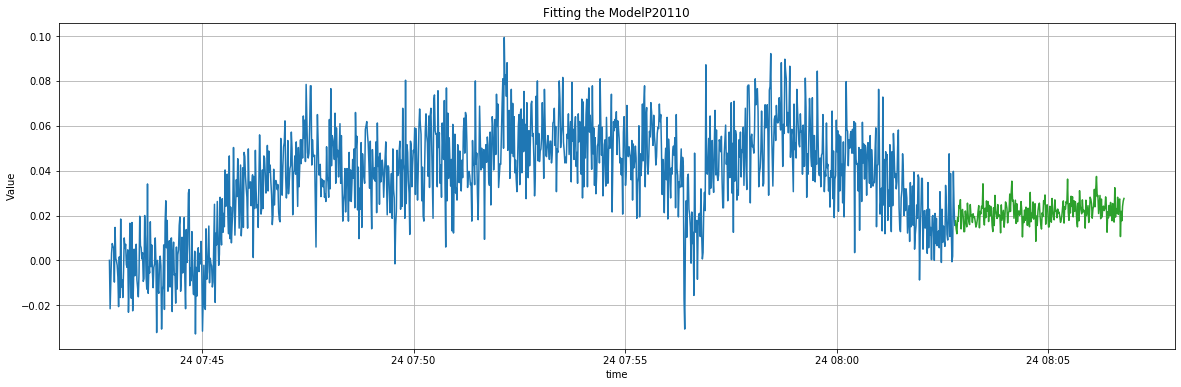

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


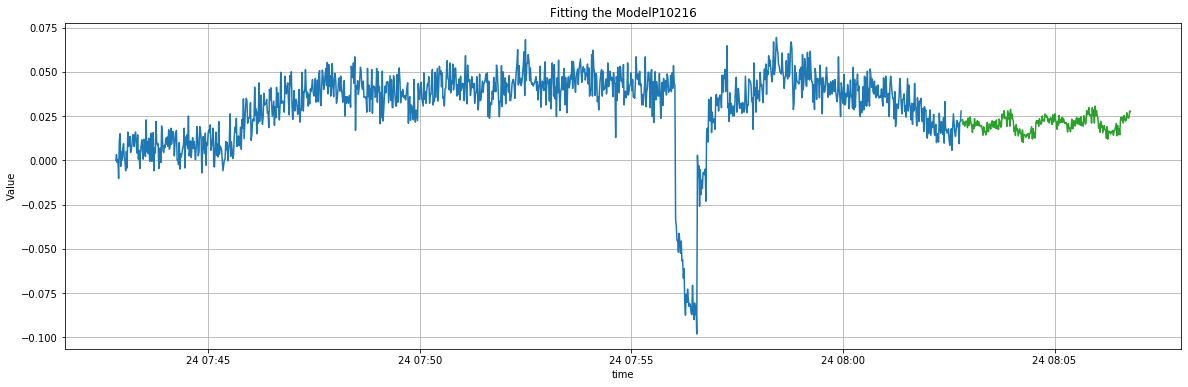

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


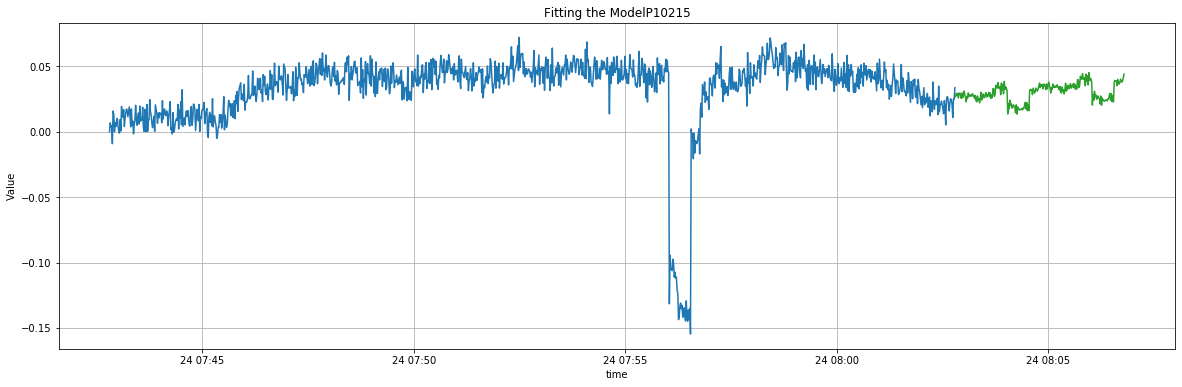

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


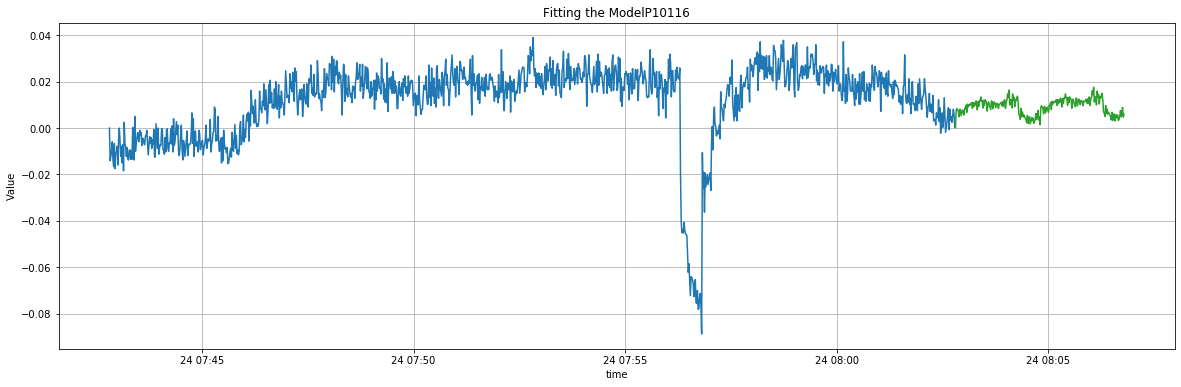

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


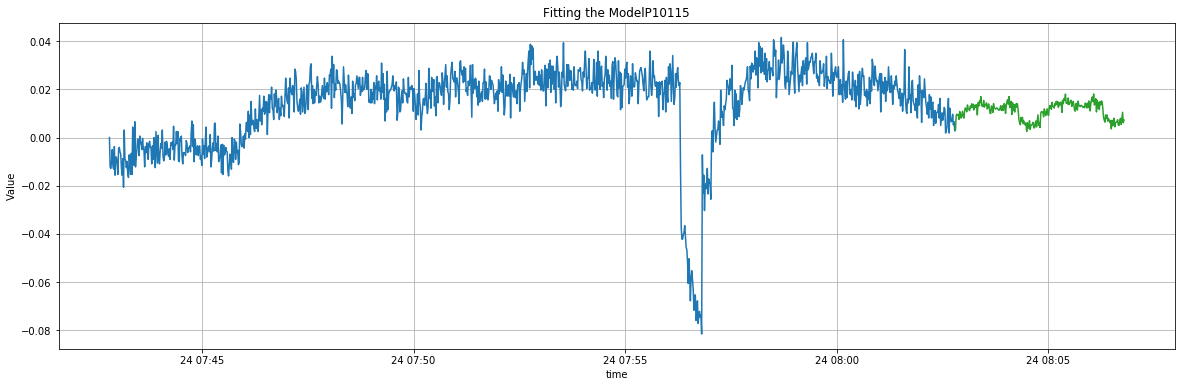

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


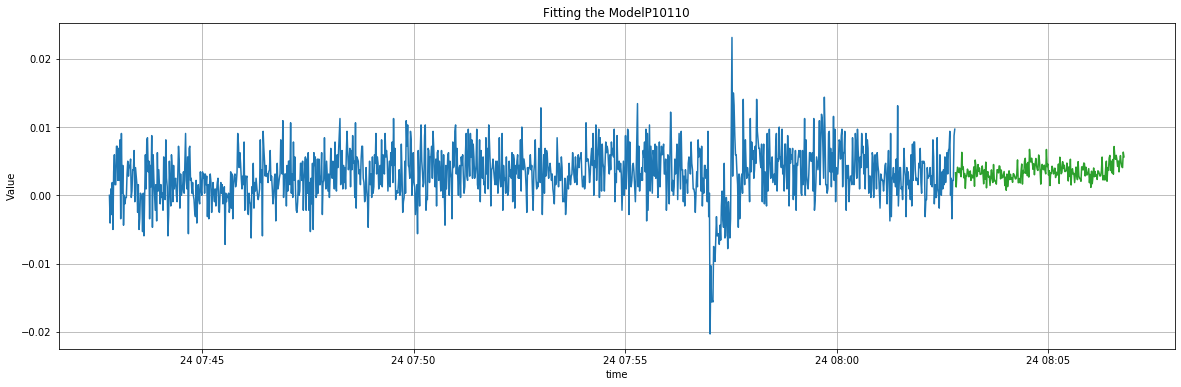

C:\Users\20522\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


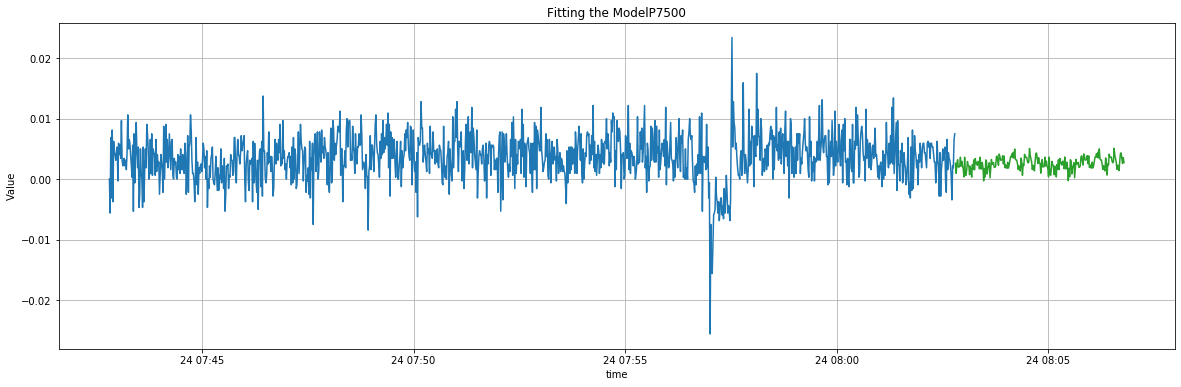

In [9]:
prediction_data(df)

In [10]:
def autocor(df):
    columns = df.columns
    for column in columns[1:]:
        print(acf(df[column]))

        pl.figure(figsize=(20, 8))
        lag_plot(df[column])    

        x = pd.DataFrame(df[str(column)])          
        fig, ax = plt.subplots(figsize=(20,6))
        plot_pacf(x, lags=100, ax=ax)
        pyplot.show()

        dfx = pd.DataFrame(df[str(column)])
        plt.figure(figsize=(20, 6))
        autocorrelation_plot(dfx) # [100:200] 


[1.         0.6402646  0.65639726 0.60812346 0.6262383  0.60364628
 0.639474   0.62867837 0.60687166 0.60419697 0.60428272 0.59055596
 0.61258168 0.60356212 0.58460733 0.5753919  0.57056783 0.54433982
 0.54874784 0.55368881 0.55664551 0.54847105 0.55752367 0.53526854
 0.52584063 0.52325056 0.52607481 0.52188574 0.52842386 0.51369938
 0.48175698 0.50419084 0.49436847 0.50039967 0.47361154 0.47412908
 0.47024664 0.48520872 0.47654549 0.47676627 0.47037838]


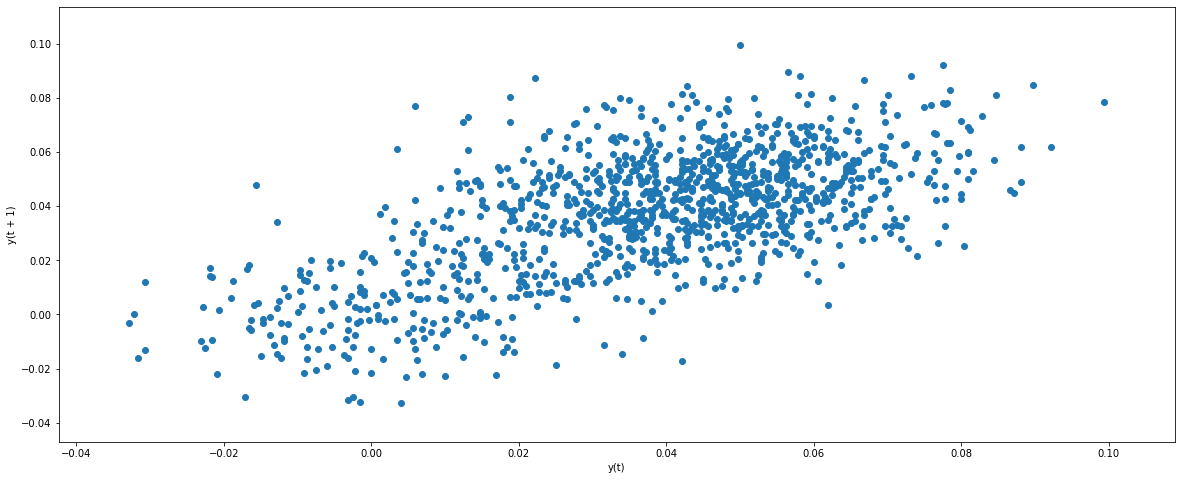

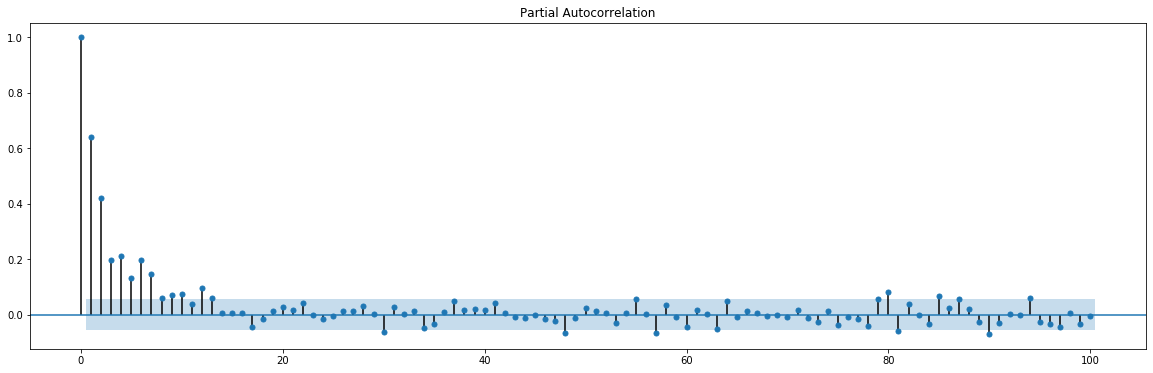

[1.         0.87985648 0.87873827 0.84749166 0.85097269 0.82049033
 0.8111937  0.79929841 0.77939063 0.76794005 0.74780826 0.7344902
 0.71954649 0.70813824 0.67890045 0.65627583 0.63425523 0.60054761
 0.58210519 0.56012635 0.53785791 0.51946088 0.49969796 0.47829486
 0.45488968 0.43753852 0.4195136  0.399382   0.37210203 0.35630387
 0.33189504 0.31319091 0.30065169 0.29557924 0.28579593 0.28098527
 0.26390263 0.26164787 0.24956438 0.2415312  0.22770873]


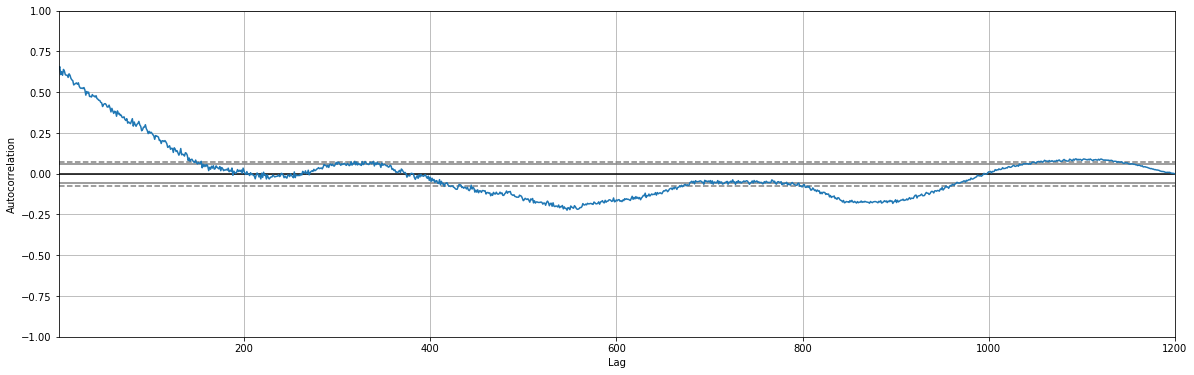

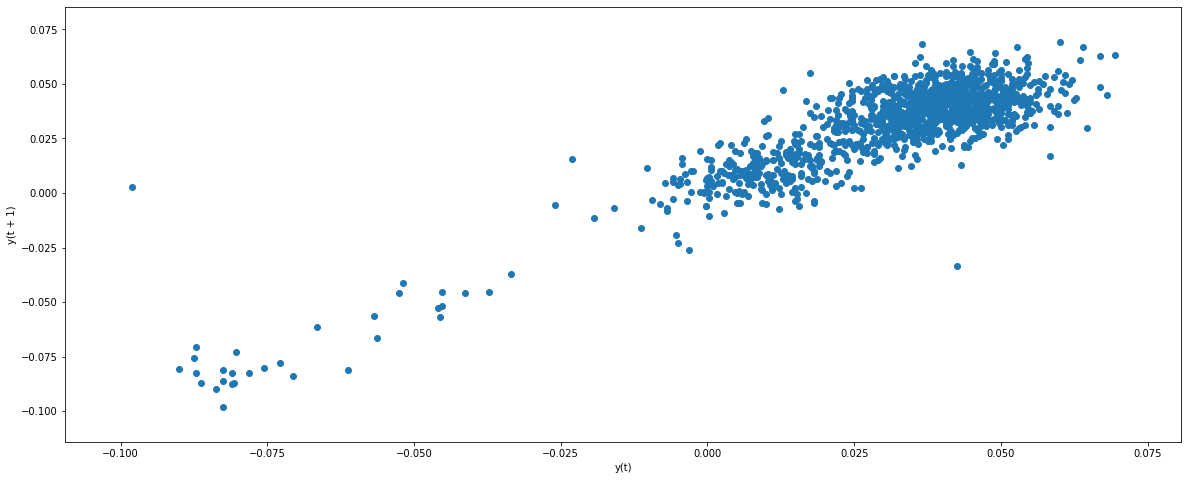

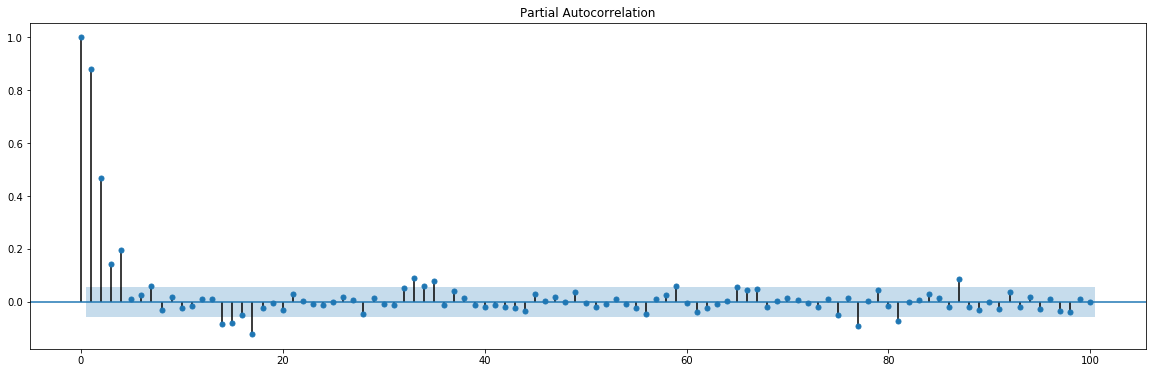

[1.         0.91325022 0.90145043 0.87140251 0.86117911 0.83132365
 0.81523236 0.79723125 0.77439893 0.75574688 0.73462813 0.71351024
 0.6914986  0.67343012 0.63907083 0.61095636 0.58652135 0.55182514
 0.52657362 0.49973505 0.47264571 0.44832059 0.42315332 0.3969933
 0.37019577 0.34913938 0.32652946 0.29876116 0.27112014 0.24541239
 0.2211517  0.19278764 0.18383459 0.18018474 0.17431263 0.16514417
 0.15719016 0.15068343 0.14203778 0.13175752 0.1225539 ]


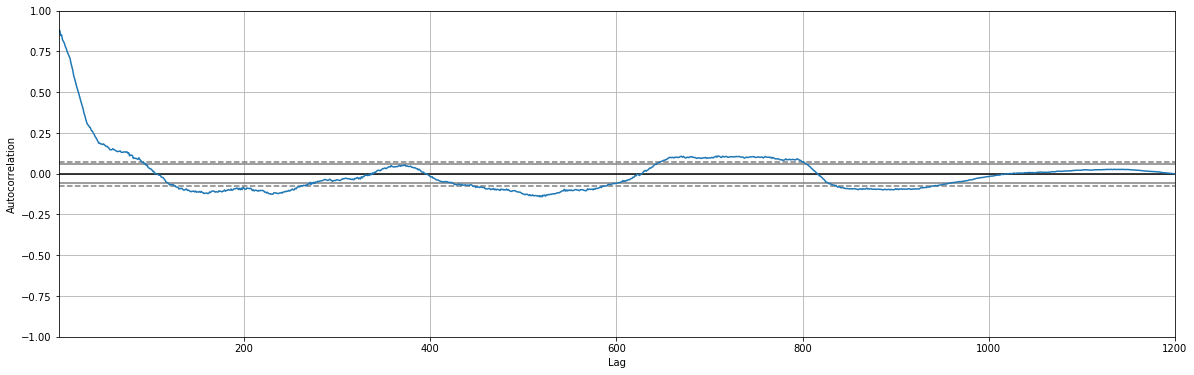

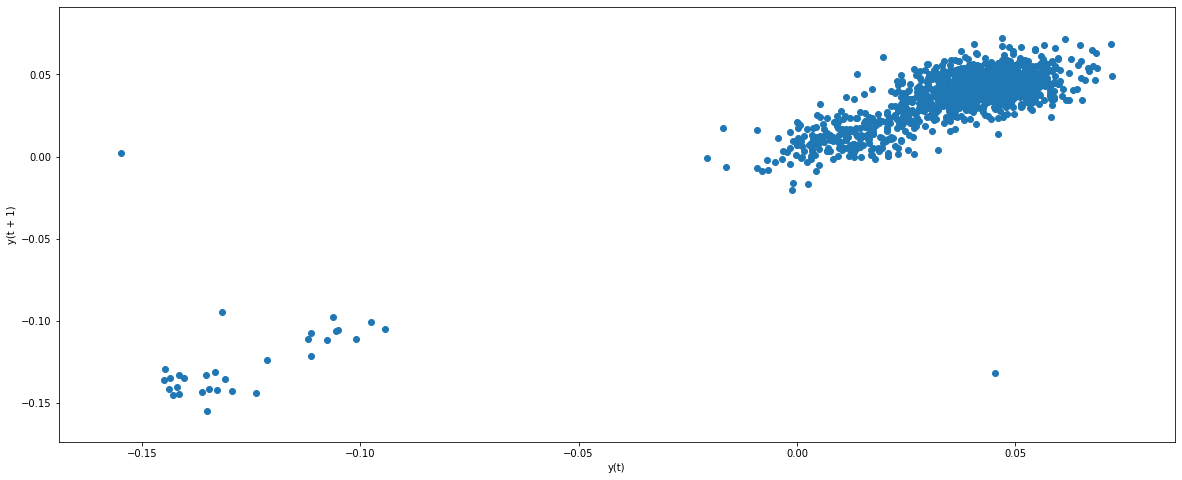

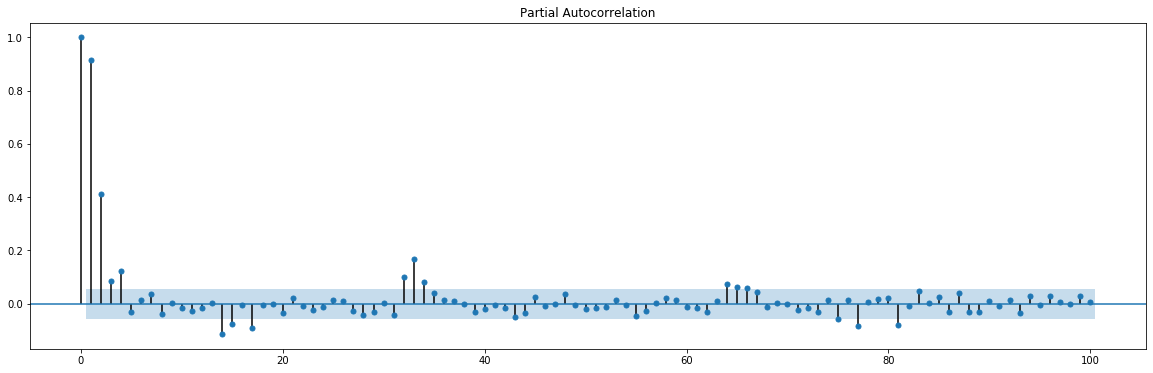

[1.         0.90198379 0.89320717 0.86650563 0.86894153 0.8475958
 0.83777278 0.8271809  0.80829541 0.79285124 0.77832869 0.76142836
 0.75070453 0.73520247 0.71038898 0.68921625 0.66489281 0.64372073
 0.61980244 0.60491588 0.58580281 0.56638567 0.55104407 0.53439899
 0.51173379 0.492979   0.47805361 0.45907175 0.43645264 0.41503105
 0.39158157 0.37922526 0.372669   0.36126549 0.34687577 0.34267141
 0.33291614 0.32454393 0.31380424 0.30337794 0.29082688]


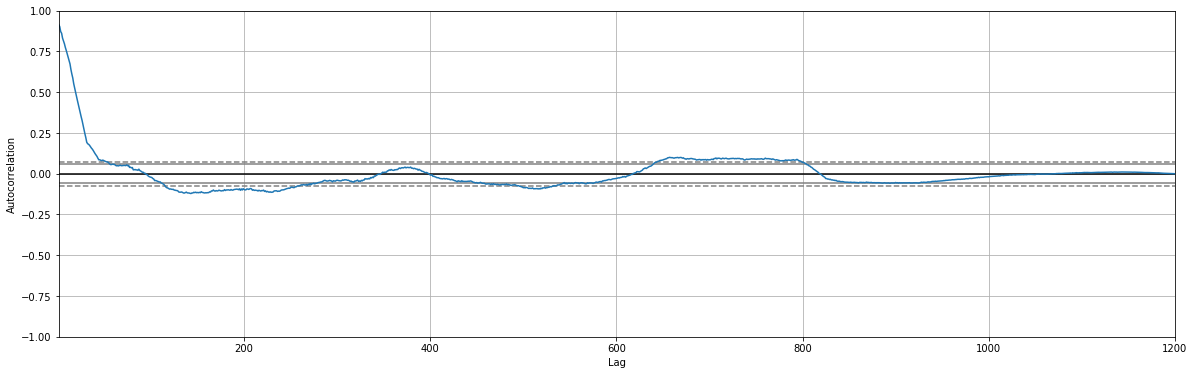

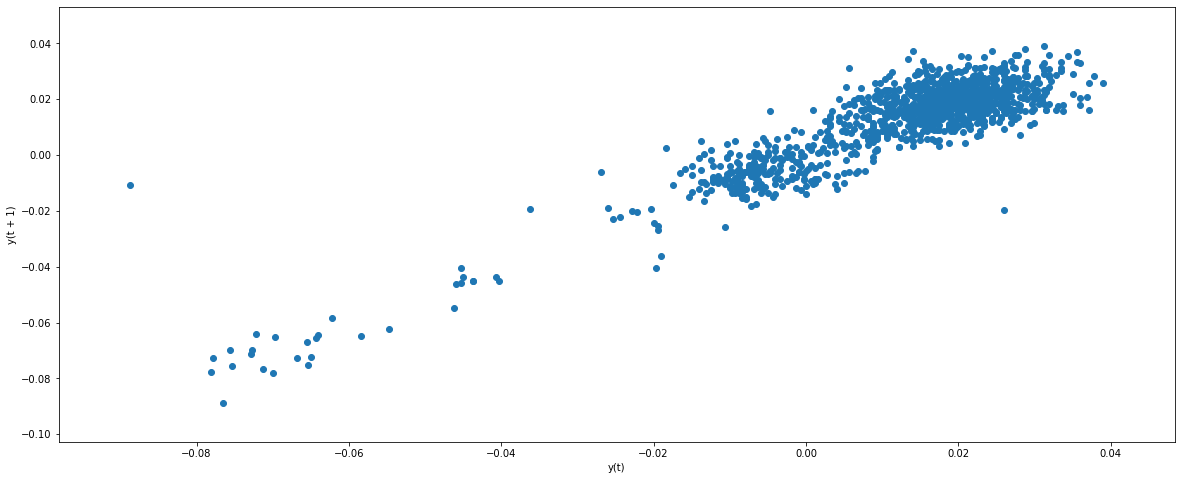

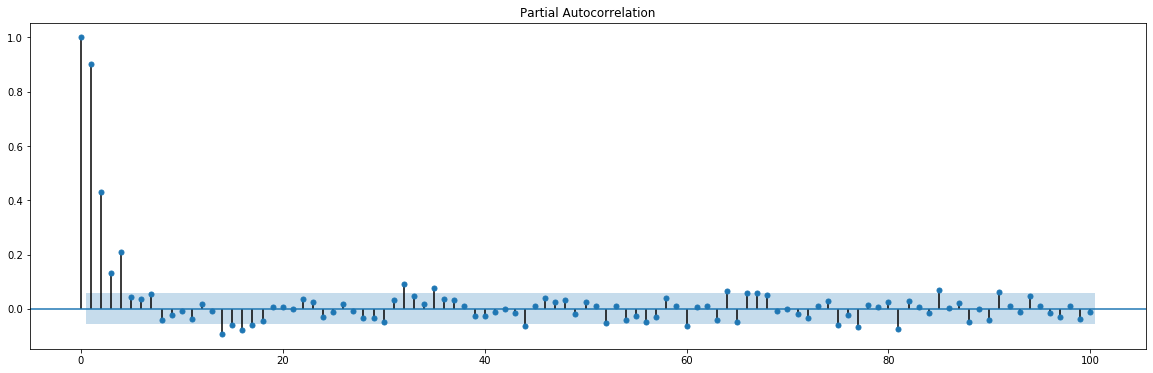

[1.         0.90268121 0.89609629 0.87011895 0.8699081  0.84776794
 0.8390903  0.83135503 0.81033709 0.79768527 0.78281911 0.76612557
 0.7553077  0.74117223 0.71952704 0.70053055 0.67763174 0.65848105
 0.63691369 0.62186767 0.60579858 0.58666704 0.56783215 0.54657293
 0.5258205  0.50661183 0.49134844 0.47396048 0.4538656  0.4311145
 0.40954344 0.4021559  0.39293996 0.38284969 0.36764839 0.36481803
 0.35107878 0.34431168 0.33587263 0.32686727 0.31095754]


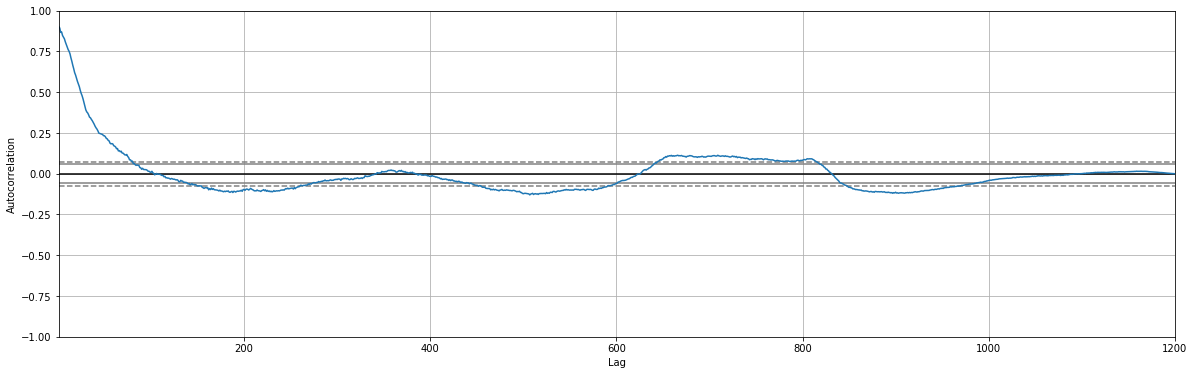

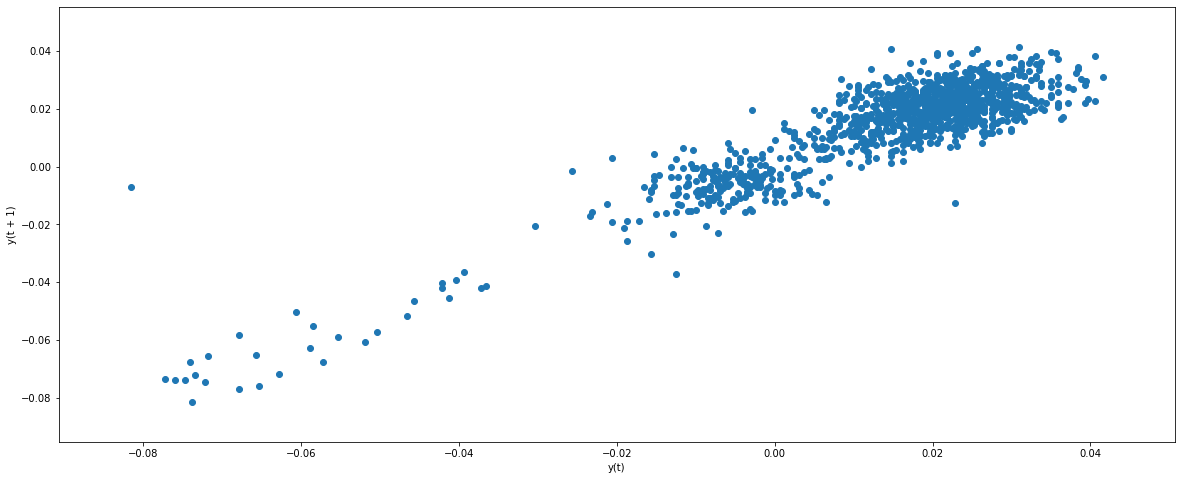

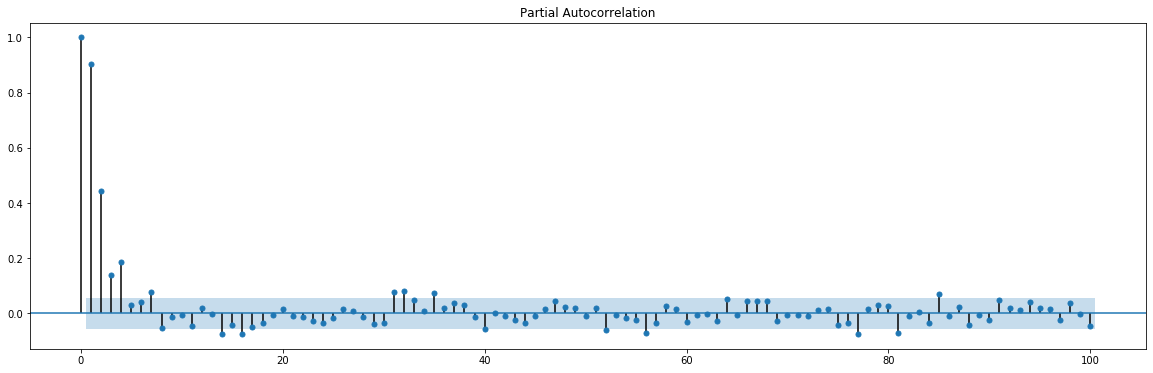

[ 1.          0.25423442  0.32632697  0.24961493  0.28348172  0.11263992
  0.19596826  0.12410329  0.14656361  0.12958237  0.15323568  0.13055091
  0.09731725  0.14123628  0.12229141  0.14187023  0.10775147  0.13511329
  0.07267177  0.12553015  0.0717829   0.09203629  0.073405    0.09975737
  0.08342535  0.0993692   0.07502638  0.06621968  0.06974339  0.03880667
 -0.01266612 -0.00541452  0.04535132  0.02845515  0.05884726  0.05368897
  0.08649057  0.09231265  0.06943837  0.06154204  0.06438526]


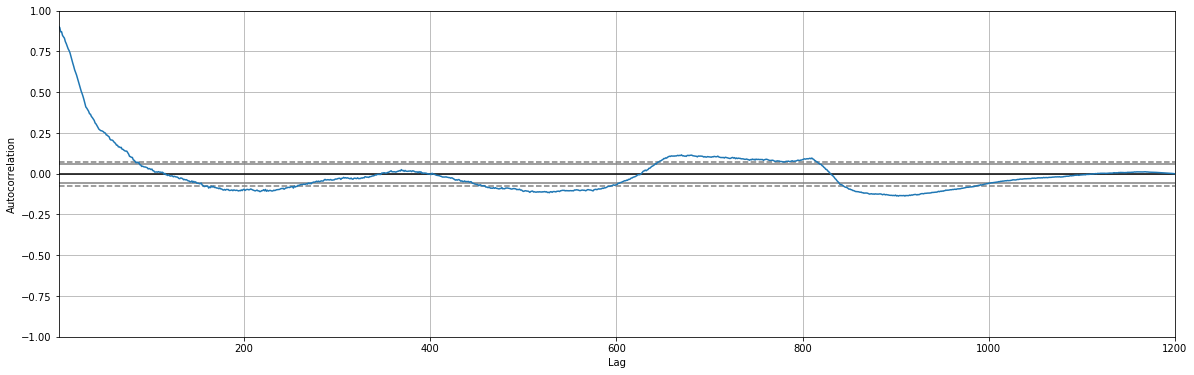

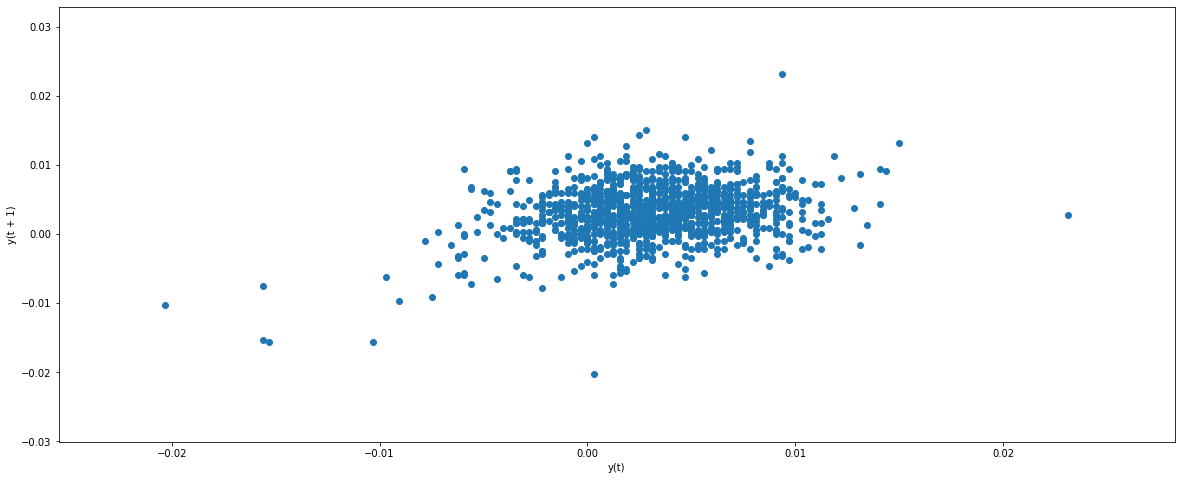

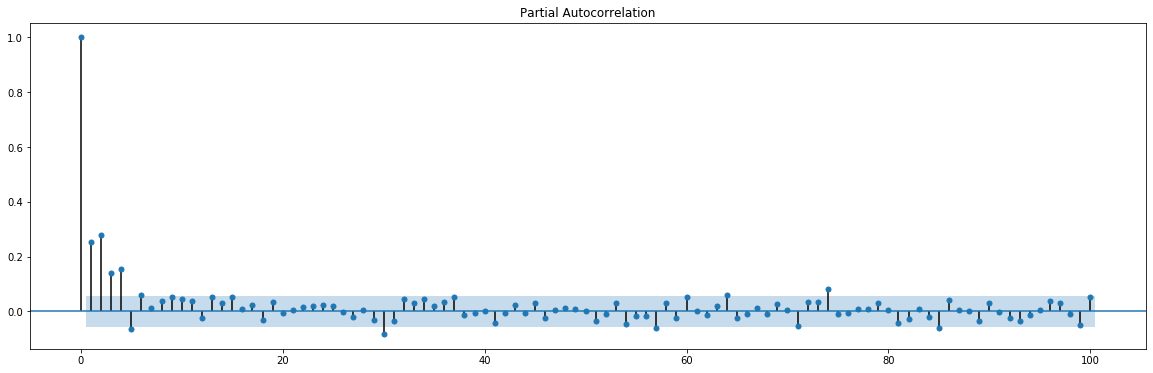

[ 1.          0.23253832  0.33059468  0.18604415  0.26041116  0.08461346
  0.11450317  0.12134479  0.11947645  0.14122033  0.08792577  0.09859457
  0.09523915  0.11637085  0.07853232  0.09760983  0.13067337  0.0818841
  0.07663504  0.10029229  0.07842069  0.06406985  0.09806086  0.10017656
  0.08716359  0.08162254  0.02979704  0.06860785  0.04258368 -0.003085
 -0.02939554 -0.01887502  0.00812279 -0.02664973  0.03302459  0.05443251
  0.09042332  0.04854868  0.03992904  0.04028536  0.0107702 ]


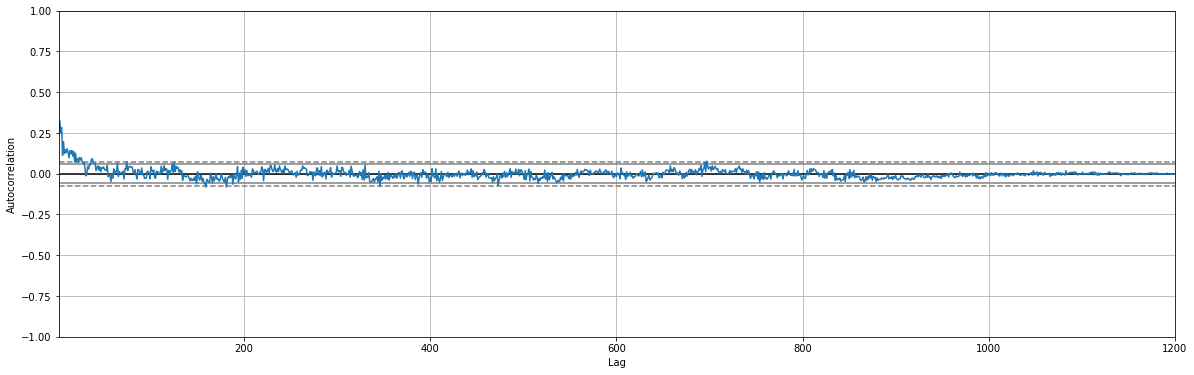

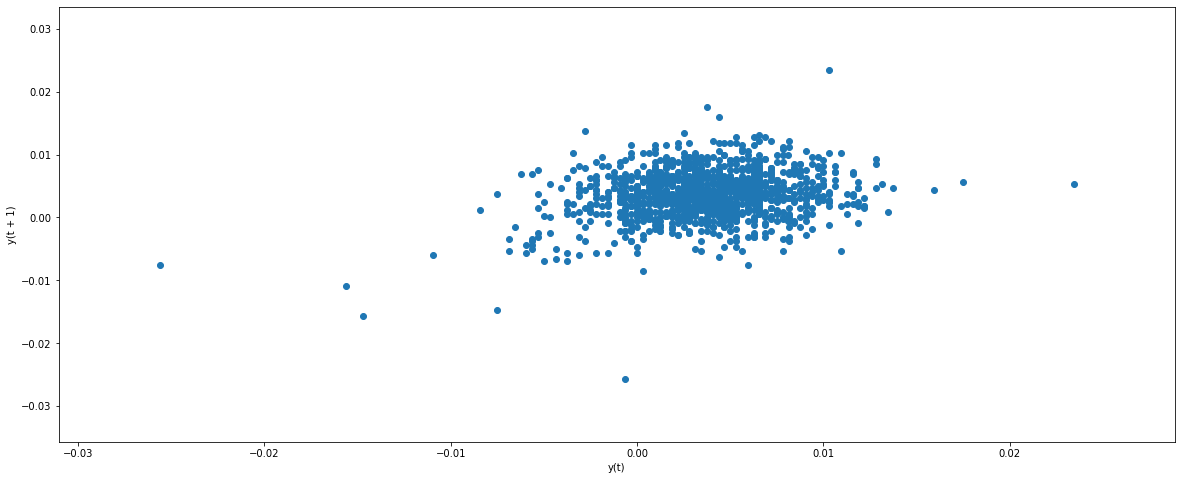

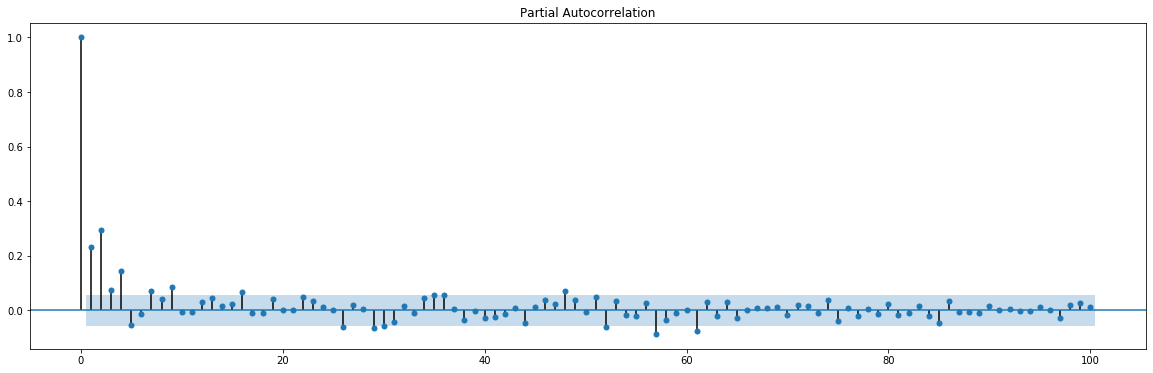

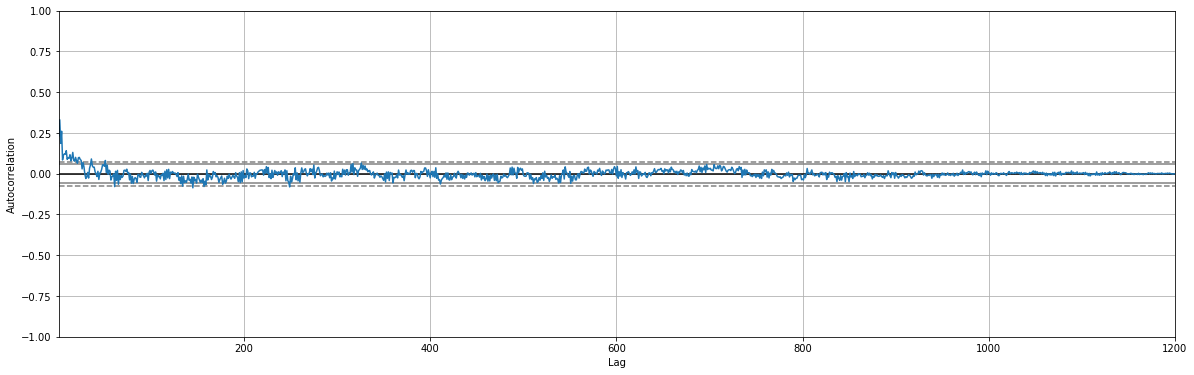

In [11]:
autocor(df)

In [12]:
def comparison_with_neares_sensor(df):
    columns = df.columns
    i= 0
    for column in columns[:-1]:        
        title = "Simple plot of data"
        ylabel=columns_names
        xlabel=''
        ax = df[columns[i:i+2]].plot(figsize=(20,6),title=title)
        ax.autoscale(axis='x',tight=True)
        i = i + 1

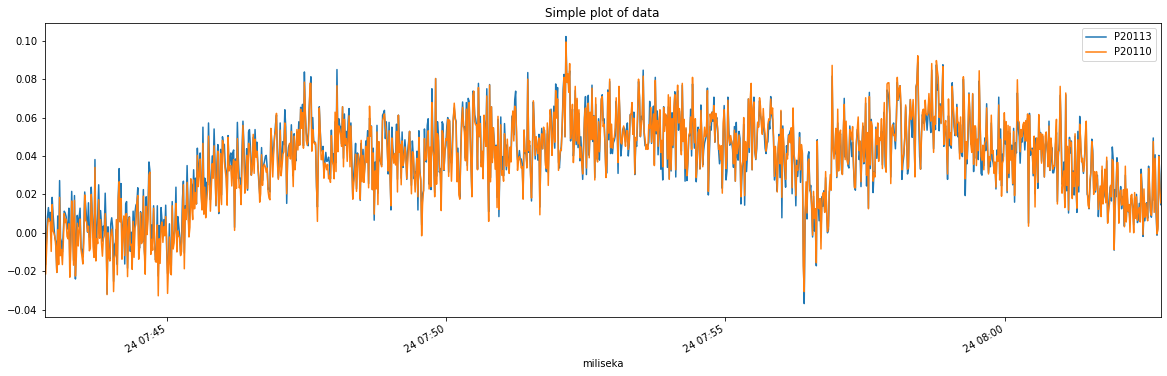

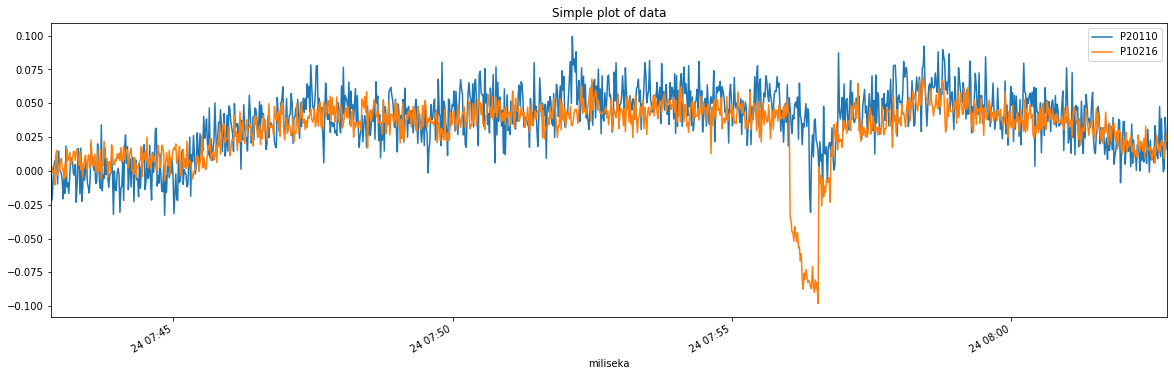

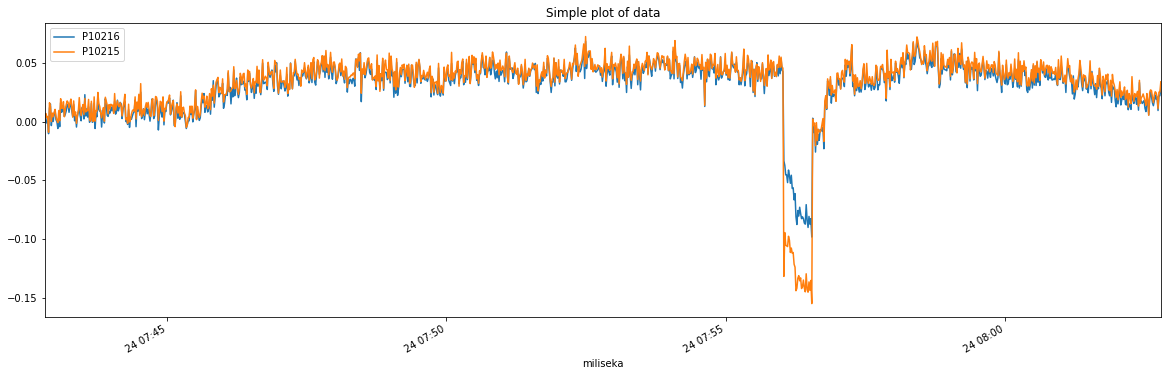

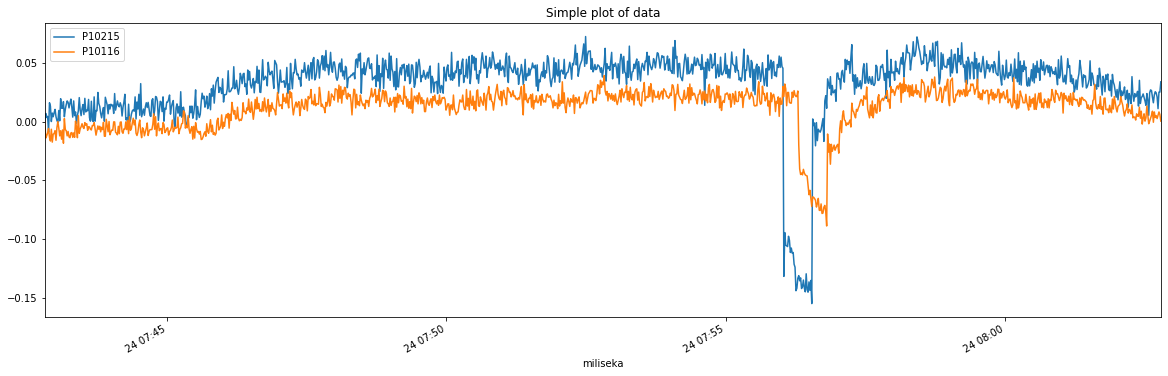

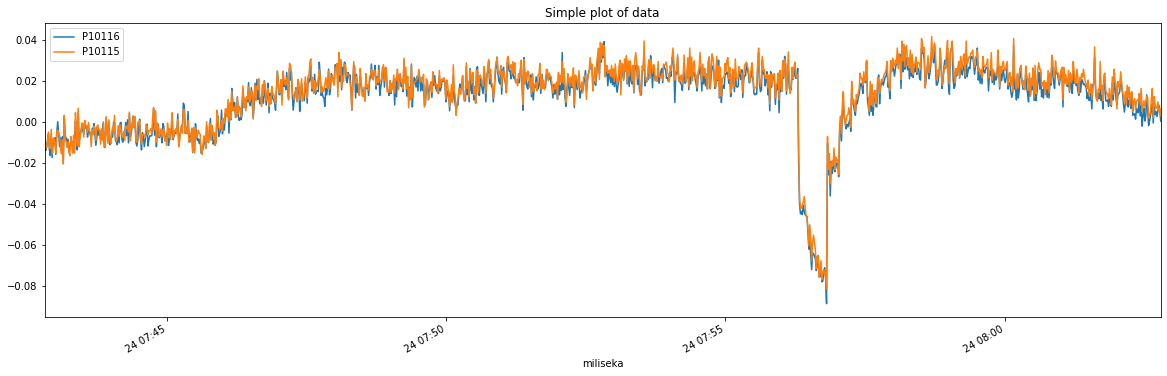

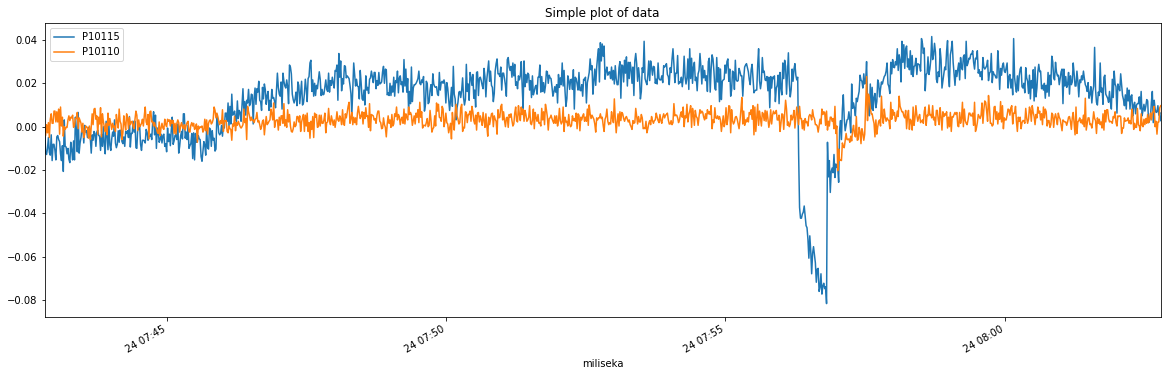

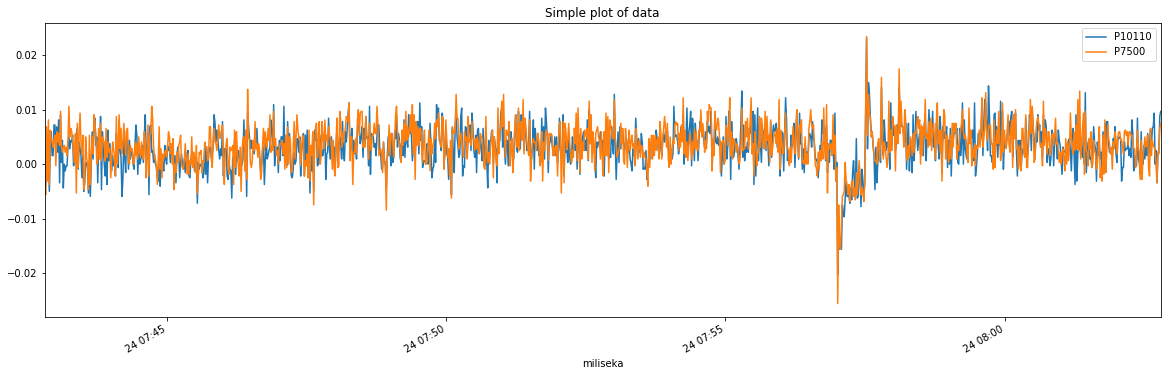

In [13]:
comparison_with_neares_sensor(df)